In [1]:
!pip install torchmetrics segmentation_models_pytorch scikit-image medpy

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torchmetrics.functional import dice, jaccard_index, accuracy

from segmentation_models_pytorch.losses import DiceLoss, TverskyLoss, FocalLoss

from src.medicalDataLoader import *
from src.utils import getTargetSegmentation, plot_img
from UNET_perso import *

In [4]:
## Parameters & Hyperparameters ##
EPOCHS = 25
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL = 8
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

## Model ##
model = UNET(in_channels=1, out_channels=4).to(DEVICE)

## Loss ##
lossCE = nn.CrossEntropyLoss().to(DEVICE)
lossDice = DiceLoss(mode='multiclass').to(DEVICE)

## optimizer ##
optimizer = torch.optim.NAdam(model.parameters(), lr=LR)

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
ROOT_DIR = './Data'
train_set = MedicalImageDataset('train',
                                    ROOT_DIR,
                                    transform=transform,
                                    mask_transform=transform,
                                    augment=True,
                                    equalize=False)

train_loader = DataLoader(train_set,
                              batch_size=BATCH_SIZE_TRAIN,
                              shuffle=True)
    
val_set = MedicalImageDataset('val',
                            ROOT_DIR,
                            transform=transform,
                            mask_transform=transform,
                            equalize=False)

val_loader = DataLoader(val_set,
                            batch_size=BATCH_SIZE_VAL,
                            shuffle=False)
    
test_set = MedicalImageDataset('test',
                                ROOT_DIR,
                                transform=transform,
                                mask_transform=transform,
                                equalize=False)

test_loader = DataLoader(test_set,
                            batch_size=BATCH_SIZE_VAL,
                            shuffle=False)

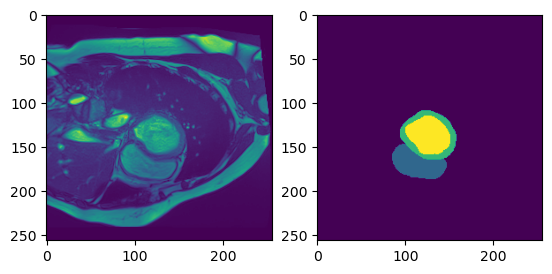

In [6]:
img_sample = next(iter(test_loader))[0][0,0]
label_sample = next(iter(test_loader))[1][0,0]
plt.subplot(121), plt.imshow(img_sample)
plt.subplot(122), plt.imshow(label_sample);

In [7]:
def train(dataLoader, model, optimizer, epoch, loss_fn1, loss_fn2=None):
    print(f'~~~ train for epoch {epoch} ~~~')
    model.train()
    loop = tqdm(dataLoader)
    train_loss = 0
    for i, (img, labels, name) in enumerate(loop):
        if torch.cuda.is_available():
            labels = getTargetSegmentation(labels)
            img, labels = img.to(DEVICE), labels.to(DEVICE)
            yPred = model(img)
            if loss_fn2!=None:
                loss = 0.5*loss_fn1(yPred, labels) + 0.5*loss_fn2(yPred, labels)
            else : loss = loss_fn1(yPred, labels)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    

        loop.set_postfix(loss=loss.item()/len(dataLoader))
    print('total train loss : {:.4f}\n'.format(train_loss/len(dataLoader.dataset)))
    return train_loss/len(dataLoader.dataset)

In [8]:
def test(dataLoader, model, epoch, loss_fn1, loss_fn2=None):
    print(f'~~~ validation for epoch {epoch} ~~~')
    model.eval()
    size = len(dataLoader)
    loop = tqdm(dataLoader)
    test_loss = 0
    Acc = 0
    Dsc1, Dsc2, Dsc3 = 0, 0, 0
    IOU1, IOU2, IOU3 = 0, 0, 0
    for i, (img, labels, name) in enumerate(loop):
        if torch.cuda.is_available():
            labels = getTargetSegmentation(labels)
            img, labels = img.to(DEVICE), labels.to(DEVICE)
            yPred = model(img)
            
            if loss_fn2!=None:
                loss = 0.5*loss_fn1(yPred, labels) + 0.5*loss_fn2(yPred, labels)
            else : loss = loss_fn1(yPred, labels) 
            
            test_loss += loss.item()
            loop.set_postfix(loss=loss.item()/len(dataLoader))
            Dsc = dice(yPred, labels, average='none', num_classes=4).cpu()
            IOU = jaccard_index(yPred, labels, task='multiclass', average='none', num_classes=4).cpu()
            Dsc1 += Dsc[1]
            Dsc2 += Dsc[2]
            Dsc3 += Dsc[3]
            IOU1 += IOU[1]
            IOU2 += IOU[2]
            IOU3 += IOU[3]
    print('total test loss : {:.4f}\nDice score 1 : {:.4f} | Dice score 2 : {:.4f} | Dice score 3 : {:.4f}\nIOU 1 : {:.4f} | IOU 2 : {:.4f} | IOU 3 : {:.4f}\n'.format(test_loss/size, Dsc1/size, Dsc2/size, Dsc3/size, IOU1/size, IOU2/size, IOU3/size))
    return test_loss/size, Dsc1/size, Dsc2/size, Dsc3/size, IOU1/size, IOU2/size, IOU3/size

In [9]:
train_loss_lst, test_loss_lst = [], []
Acc_lst = []
Dsc1_lst, Dsc2_lst, Dsc3_lst = [], [], []
IOU1_lst, IOU2_lst, IOU3_lst = [], [], []
for i in range(EPOCHS):
    train_loss = train(train_loader, model, optimizer, i+1, lossCE, lossDice)
    test_loss, Dsc1, Dsc2, Dsc3, IOU1, IOU2, IOU3 = test(test_loader, model, i+1, lossCE, lossDice)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    Dsc1_lst.append(Dsc1)
    Dsc2_lst.append(Dsc2)
    Dsc3_lst.append(Dsc3)
    IOU1_lst.append(IOU1)
    IOU2_lst.append(IOU2)
    IOU3_lst.append(IOU3)

~~~ train for epoch 1 ~~~


100%|██████████| 151/151 [01:15<00:00,  2.00it/s, loss=0.00279]


total train loss : 0.0672

~~~ validation for epoch 1 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.06it/s, loss=0.0103] 


total test loss : 0.4156
Dice score 1 : 0.0000 | Dice score 2 : 0.0936 | Dice score 3 : 0.0035
IOU 1 : 0.0000 | IOU 2 : 0.0514 | IOU 3 : 0.0018

~~~ train for epoch 2 ~~~


100%|██████████| 151/151 [01:14<00:00,  2.01it/s, loss=0.00213]


total train loss : 0.0436

~~~ validation for epoch 2 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.19it/s, loss=0.0107] 


total test loss : 0.3561
Dice score 1 : 0.1286 | Dice score 2 : 0.2539 | Dice score 3 : 0.3024
IOU 1 : 0.0778 | IOU 2 : 0.1657 | IOU 3 : 0.2107

~~~ train for epoch 3 ~~~


100%|██████████| 151/151 [01:17<00:00,  1.95it/s, loss=0.00166]


total train loss : 0.0338

~~~ validation for epoch 3 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.0132] 


total test loss : 0.4082
Dice score 1 : 0.1070 | Dice score 2 : 0.1826 | Dice score 3 : 0.3390
IOU 1 : 0.0621 | IOU 2 : 0.1092 | IOU 3 : 0.2135

~~~ train for epoch 4 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.89it/s, loss=0.00132] 


total train loss : 0.0264

~~~ validation for epoch 4 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.00817]


total test loss : 0.2293
Dice score 1 : 0.4215 | Dice score 2 : 0.4047 | Dice score 3 : 0.6631
IOU 1 : 0.2921 | IOU 2 : 0.2735 | IOU 3 : 0.5181

~~~ train for epoch 5 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.00142] 


total train loss : 0.0207

~~~ validation for epoch 5 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.96it/s, loss=0.0102] 


total test loss : 0.1883
Dice score 1 : 0.5719 | Dice score 2 : 0.5499 | Dice score 3 : 0.6831
IOU 1 : 0.4323 | IOU 2 : 0.4113 | IOU 3 : 0.5713

~~~ train for epoch 6 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000892]


total train loss : 0.0163

~~~ validation for epoch 6 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.00536]


total test loss : 0.1772
Dice score 1 : 0.4737 | Dice score 2 : 0.6827 | Dice score 3 : 0.7129
IOU 1 : 0.3532 | IOU 2 : 0.5267 | IOU 3 : 0.5802

~~~ train for epoch 7 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000566]


total train loss : 0.0134

~~~ validation for epoch 7 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.00162]


total test loss : 0.0896
Dice score 1 : 0.7882 | Dice score 2 : 0.7698 | Dice score 3 : 0.8936
IOU 1 : 0.6639 | IOU 2 : 0.6347 | IOU 3 : 0.8149

~~~ train for epoch 8 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000856]


total train loss : 0.0107

~~~ validation for epoch 8 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.00126]


total test loss : 0.0848
Dice score 1 : 0.8167 | Dice score 2 : 0.7669 | Dice score 3 : 0.8915
IOU 1 : 0.7050 | IOU 2 : 0.6273 | IOU 3 : 0.8145

~~~ train for epoch 9 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000571]


total train loss : 0.0099

~~~ validation for epoch 9 ~~~


100%|██████████| 40/40 [00:08<00:00,  5.00it/s, loss=0.00264] 


total test loss : 0.0774
Dice score 1 : 0.8148 | Dice score 2 : 0.8003 | Dice score 3 : 0.9015
IOU 1 : 0.7075 | IOU 2 : 0.6734 | IOU 3 : 0.8285

~~~ train for epoch 10 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000624]


total train loss : 0.0097

~~~ validation for epoch 10 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.96it/s, loss=0.00106] 


total test loss : 0.0625
Dice score 1 : 0.8547 | Dice score 2 : 0.8372 | Dice score 3 : 0.9209
IOU 1 : 0.7534 | IOU 2 : 0.7231 | IOU 3 : 0.8555

~~~ train for epoch 11 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000769]


total train loss : 0.0090

~~~ validation for epoch 11 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.99it/s, loss=0.00121] 


total test loss : 0.0629
Dice score 1 : 0.8340 | Dice score 2 : 0.8477 | Dice score 3 : 0.9240
IOU 1 : 0.7269 | IOU 2 : 0.7385 | IOU 3 : 0.8617

~~~ train for epoch 12 ~~~


100%|██████████| 151/151 [01:16<00:00,  1.96it/s, loss=0.000392]


total train loss : 0.0083

~~~ validation for epoch 12 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.27it/s, loss=0.00101] 


total test loss : 0.0658
Dice score 1 : 0.8513 | Dice score 2 : 0.8230 | Dice score 3 : 0.9233
IOU 1 : 0.7489 | IOU 2 : 0.7044 | IOU 3 : 0.8597

~~~ train for epoch 13 ~~~


100%|██████████| 151/151 [01:14<00:00,  2.03it/s, loss=0.000294]


total train loss : 0.0082

~~~ validation for epoch 13 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.27it/s, loss=0.00079] 


total test loss : 0.0577
Dice score 1 : 0.8752 | Dice score 2 : 0.8381 | Dice score 3 : 0.9258
IOU 1 : 0.7839 | IOU 2 : 0.7275 | IOU 3 : 0.8649

~~~ train for epoch 14 ~~~


100%|██████████| 151/151 [01:14<00:00,  2.02it/s, loss=0.000378]


total train loss : 0.0078

~~~ validation for epoch 14 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.21it/s, loss=0.000895]


total test loss : 0.0642
Dice score 1 : 0.8545 | Dice score 2 : 0.8228 | Dice score 3 : 0.9188
IOU 1 : 0.7580 | IOU 2 : 0.7040 | IOU 3 : 0.8523

~~~ train for epoch 15 ~~~


100%|██████████| 151/151 [01:15<00:00,  2.00it/s, loss=0.000281]


total train loss : 0.0072

~~~ validation for epoch 15 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.31it/s, loss=0.000838]


total test loss : 0.0589
Dice score 1 : 0.8577 | Dice score 2 : 0.8472 | Dice score 3 : 0.9249
IOU 1 : 0.7600 | IOU 2 : 0.7388 | IOU 3 : 0.8640

~~~ train for epoch 16 ~~~


100%|██████████| 151/151 [01:13<00:00,  2.04it/s, loss=0.000276]


total train loss : 0.0074

~~~ validation for epoch 16 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.29it/s, loss=0.00089] 


total test loss : 0.0530
Dice score 1 : 0.8752 | Dice score 2 : 0.8626 | Dice score 3 : 0.9291
IOU 1 : 0.7878 | IOU 2 : 0.7621 | IOU 3 : 0.8735

~~~ train for epoch 17 ~~~


100%|██████████| 151/151 [01:14<00:00,  2.03it/s, loss=0.000316]


total train loss : 0.0069

~~~ validation for epoch 17 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.24it/s, loss=0.00081] 


total test loss : 0.0541
Dice score 1 : 0.8684 | Dice score 2 : 0.8647 | Dice score 3 : 0.9271
IOU 1 : 0.7767 | IOU 2 : 0.7649 | IOU 3 : 0.8719

~~~ train for epoch 18 ~~~


100%|██████████| 151/151 [01:16<00:00,  1.98it/s, loss=0.000321]


total train loss : 0.0071

~~~ validation for epoch 18 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.04it/s, loss=0.000897]


total test loss : 0.0574
Dice score 1 : 0.8686 | Dice score 2 : 0.8537 | Dice score 3 : 0.9163
IOU 1 : 0.7772 | IOU 2 : 0.7485 | IOU 3 : 0.8554

~~~ train for epoch 19 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000576]


total train loss : 0.0067

~~~ validation for epoch 19 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.97it/s, loss=0.00117] 


total test loss : 0.0685
Dice score 1 : 0.8540 | Dice score 2 : 0.8195 | Dice score 3 : 0.9040
IOU 1 : 0.7626 | IOU 2 : 0.7053 | IOU 3 : 0.8391

~~~ train for epoch 20 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.00043] 


total train loss : 0.0065

~~~ validation for epoch 20 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.001]  


total test loss : 0.0929
Dice score 1 : 0.7599 | Dice score 2 : 0.8124 | Dice score 3 : 0.8410
IOU 1 : 0.6447 | IOU 2 : 0.6954 | IOU 3 : 0.7492

~~~ train for epoch 21 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.91it/s, loss=0.000279]


total train loss : 0.0064

~~~ validation for epoch 21 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.00106] 


total test loss : 0.0498
Dice score 1 : 0.8856 | Dice score 2 : 0.8679 | Dice score 3 : 0.9359
IOU 1 : 0.8017 | IOU 2 : 0.7690 | IOU 3 : 0.8821

~~~ train for epoch 22 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.89it/s, loss=0.000382]


total train loss : 0.0061

~~~ validation for epoch 22 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.000846]


total test loss : 0.0501
Dice score 1 : 0.8698 | Dice score 2 : 0.8723 | Dice score 3 : 0.9416
IOU 1 : 0.7784 | IOU 2 : 0.7758 | IOU 3 : 0.8913

~~~ train for epoch 23 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000517]


total train loss : 0.0060

~~~ validation for epoch 23 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.93it/s, loss=0.000932]


total test loss : 0.0470
Dice score 1 : 0.8938 | Dice score 2 : 0.8752 | Dice score 3 : 0.9324
IOU 1 : 0.8141 | IOU 2 : 0.7806 | IOU 3 : 0.8803

~~~ train for epoch 24 ~~~


100%|██████████| 151/151 [01:19<00:00,  1.90it/s, loss=0.000344]


total train loss : 0.0059

~~~ validation for epoch 24 ~~~


100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.00133] 


total test loss : 0.0652
Dice score 1 : 0.8202 | Dice score 2 : 0.8615 | Dice score 3 : 0.9121
IOU 1 : 0.7185 | IOU 2 : 0.7601 | IOU 3 : 0.8422

~~~ train for epoch 25 ~~~


100%|██████████| 151/151 [01:15<00:00,  2.00it/s, loss=0.00092] 


total train loss : 0.0074

~~~ validation for epoch 25 ~~~


100%|██████████| 40/40 [00:07<00:00,  5.29it/s, loss=0.000887]

total test loss : 0.0585
Dice score 1 : 0.8609 | Dice score 2 : 0.8498 | Dice score 3 : 0.9284
IOU 1 : 0.7632 | IOU 2 : 0.7408 | IOU 3 : 0.8694



In [10]:
filepath = 'UNET_perso'
torch.save(model.state_dict(), filepath)

In [11]:
def mean_(lst1, lst2, lst3):
    M = []
    for i, val in enumerate(lst1):
        M.append((lst1[i]+lst2[i]+lst3[i])/3)
    return M

Loss	 Best Epoch : 22 | Value : 0.0470
DSC	Best Mean : 0.9005 | Best Epoch : 22 | DSC1 : 0.8938 | DSC2 : 0.8752 | DSC3 : 0.9324
IOU	Best Mean : 0.8250 | Best Epoch : 22 | IOU1 : 0.8141 | IOU2 : 0.7806 | IOU3 : 0.8803


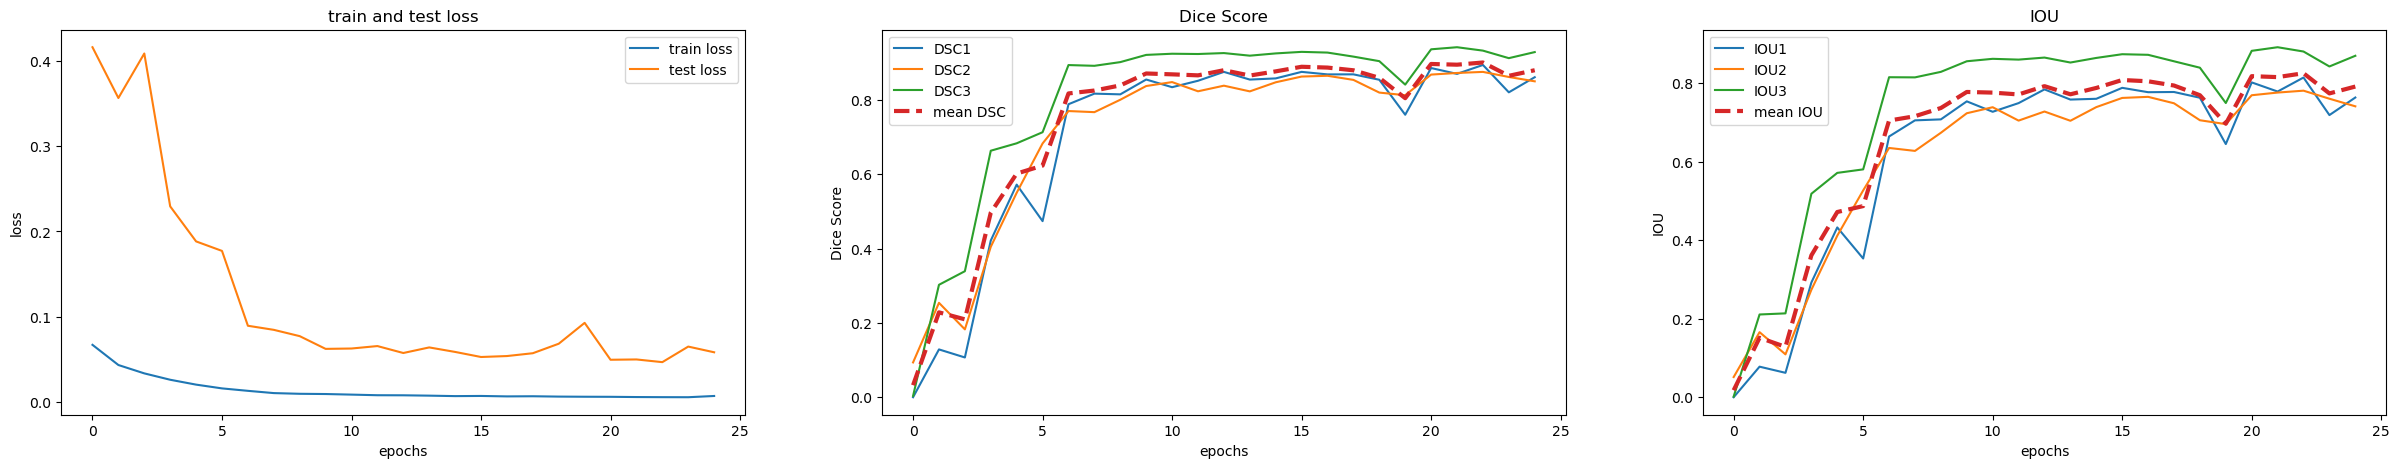

In [12]:
bestIdxLoss = np.argmin(test_loss_lst)
bestIdxDsc = np.argmax(mean_(Dsc1_lst, Dsc2_lst, Dsc3_lst))
bestIdxIOU = np.argmax(mean_(IOU1_lst, IOU2_lst, IOU3_lst))

print('Loss\t Best Epoch : {} | Value : {:.4f}'.format(bestIdxLoss, test_loss_lst[bestIdxLoss]))
print('DSC\tBest Mean : {:.4f} | Best Epoch : {} | DSC1 : {:.4f} | DSC2 : {:.4f} | DSC3 : {:.4f}'.format(np.max(mean_(Dsc1_lst, Dsc2_lst, Dsc3_lst)), bestIdxDsc, Dsc1_lst[bestIdxDsc], Dsc2_lst[bestIdxDsc], Dsc3_lst[bestIdxDsc]))
print('IOU\tBest Mean : {:.4f} | Best Epoch : {} | IOU1 : {:.4f} | IOU2 : {:.4f} | IOU3 : {:.4f}'.format(np.max(mean_(IOU1_lst, IOU2_lst, IOU3_lst)), bestIdxIOU, IOU1_lst[bestIdxIOU], IOU2_lst[bestIdxIOU], IOU3_lst[bestIdxIOU]))

plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.plot(train_loss_lst, label='train loss')
plt.plot(test_loss_lst, label='test loss')
plt.title('train and test loss'), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Dsc1_lst, label='DSC1')
plt.plot(Dsc2_lst, label='DSC2')
plt.plot(Dsc3_lst, label='DSC3')
plt.plot(mean_(Dsc1_lst, Dsc2_lst, Dsc3_lst), label='mean DSC', linestyle='dashed', linewidth=3)
plt.title('Dice Score'), plt.xlabel('epochs'), plt.ylabel('Dice Score')
plt.legend()

plt.subplot(1,3,3)
plt.plot(IOU1_lst, label='IOU1')
plt.plot(IOU2_lst, label='IOU2')
plt.plot(IOU3_lst, label='IOU3')
plt.plot(mean_(IOU1_lst, IOU2_lst, IOU3_lst), label='mean IOU', linestyle='dashed', linewidth=3)
plt.title('IOU'), plt.xlabel('epochs'), plt.ylabel('IOU')
plt.legend()

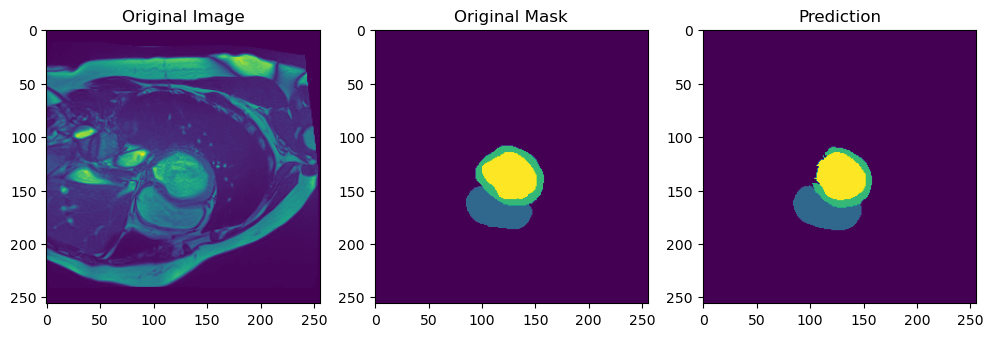

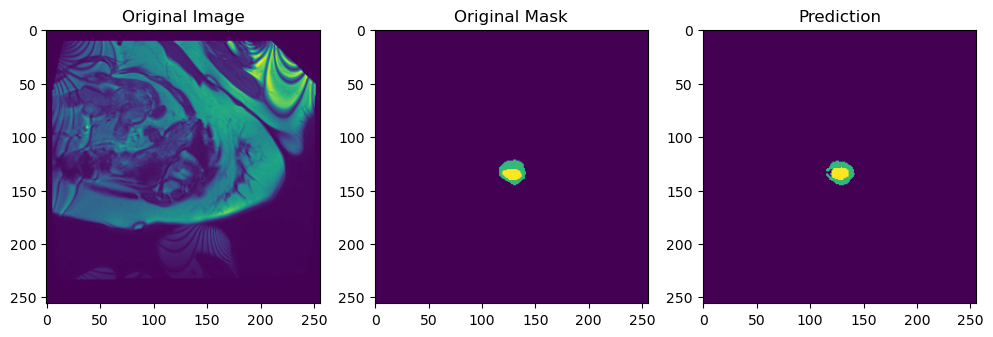

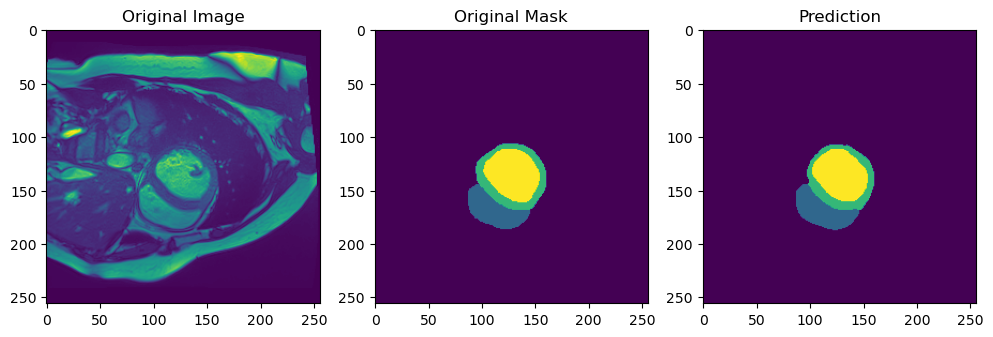

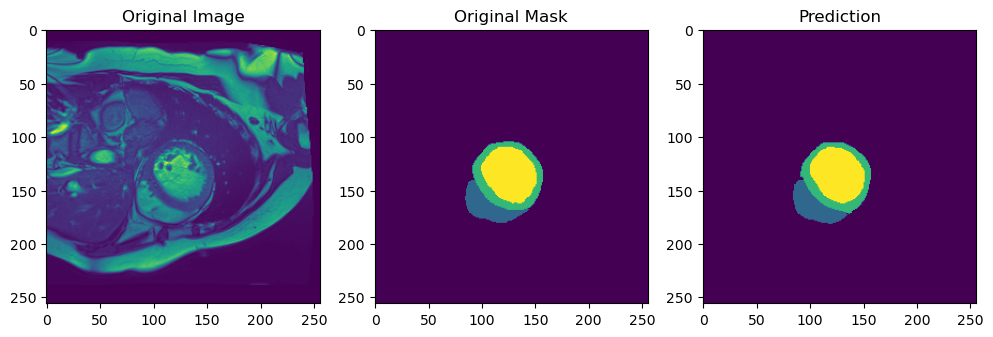

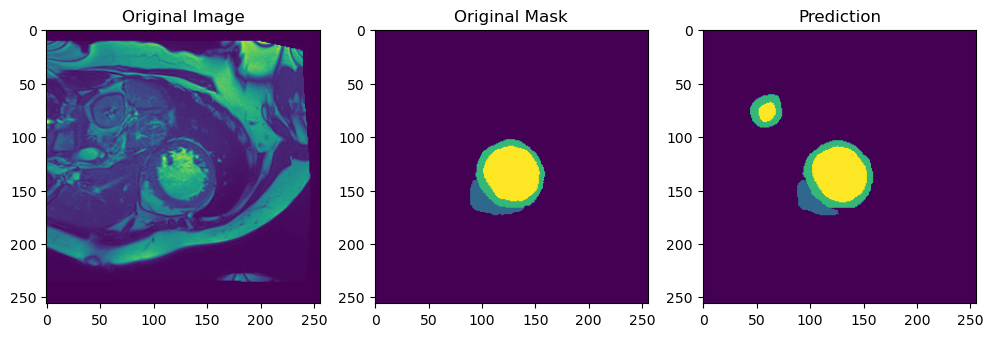

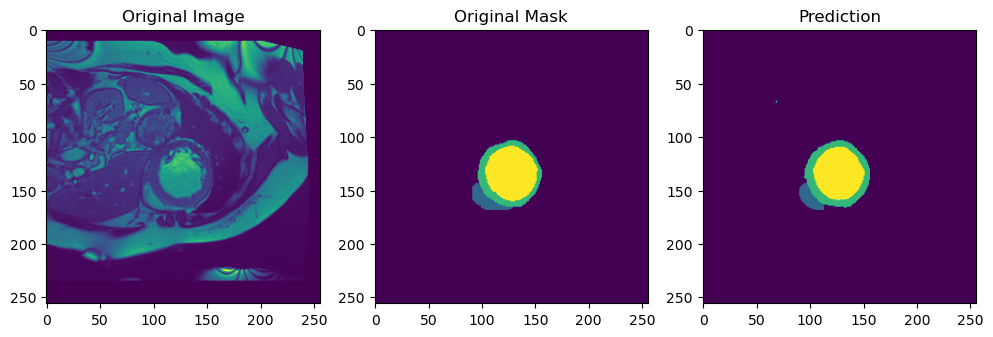

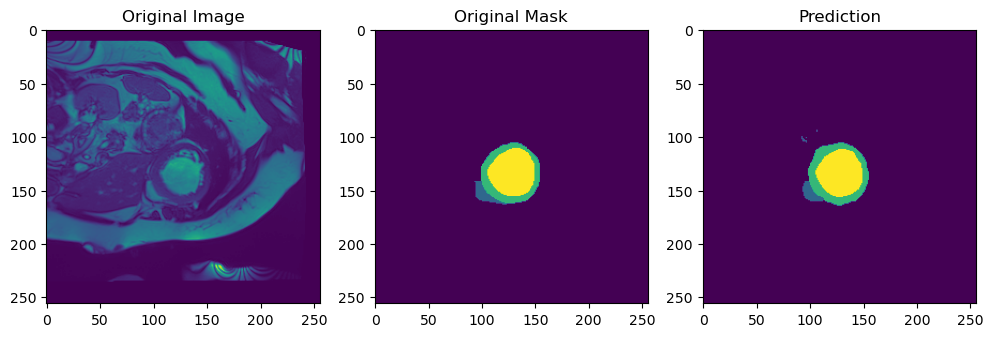

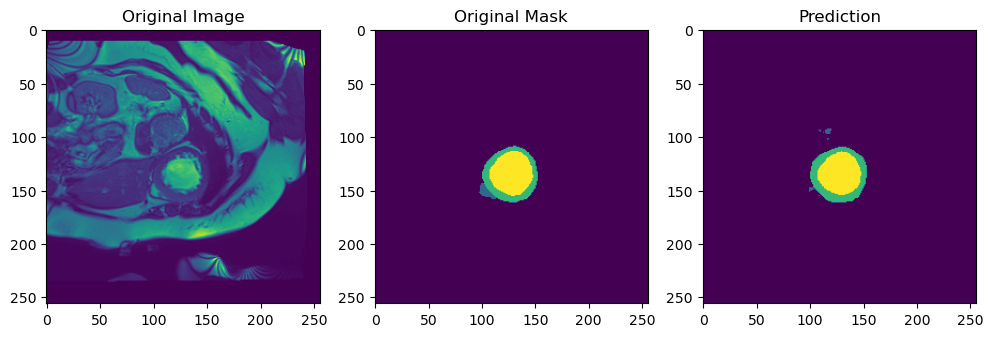

In [13]:
plot_img(test_loader, 8, model)